# Stock Price Prediction — Updated Analysis

This notebook contains an updated end-to-end analysis: preprocessing, feature engineering, model training and evaluation, and diagnostic visualizations. The code uses the project `src` modules (preprocessing + training) and the artifacts produced under `models/` (plots, metrics, saved models).

In [12]:
# Imports and notebook configuration
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import Image, display
import json, os

sns.set_theme(style='darkgrid')
%matplotlib inline

## 1 — Load preprocessed data from `src` (re-usable) and show sample

In [13]:
# Use the library functions in src to load and preprocess consistently
import sys
sys.path.append('..')  # allow importing src when running from notebooks folder
from src import preprocessing, config

df = preprocessing.load_and_preprocess()
print('Loaded dataframe shape:', df.shape)
df.head()

Loaded dataframe shape: (3797, 13)


,Date,Data,Data_Lag1,Data_Lag2,Data_Lag3,Data_Lag4,Data_Lag5,Data_Change_PrevDay,Data_Pct_Change,Data_Rolling_Mean,Data_Rolling_STD,Price,Price_Change
5,2010-01-11,0.689,0.691,0.692,0.694,0.699,0.700,-0.001,-0.002894,0.6952,0.004087,1191.75,1.00
6,2010-01-12,0.685,0.689,0.691,0.692,0.694,0.699,-0.002,-0.005806,0.6930,0.003808,1183.25,-8.50
7,2010-01-13,0.684,0.685,0.689,0.691,0.692,0.694,-0.004,-0.001460,0.6902,0.003421,1190.75,7.50
8,2010-01-14,0.682,0.684,0.685,0.689,0.691,0.692,-0.001,-0.002924,0.6882,0.003564,1194.50,3.75
9,2010-01-15,0.680,0.682,0.684,0.685,0.689,0.691,-0.002,-0.002933,0.6862,0.003701,1181.50,-13.00


## 2 — Quick EDA and assumption check
Check correlation between previous-day `Data` change and today's `Price_Change` and visualize distributions.

Correlation matrix:
                     Price_Change  Data_Change_PrevDay  Data_Pct_Change
Price_Change             1.000000             0.000507         0.036983
Data_Change_PrevDay      0.000507             1.000000         0.072282
Data_Pct_Change          0.036983             0.072282         1.000000


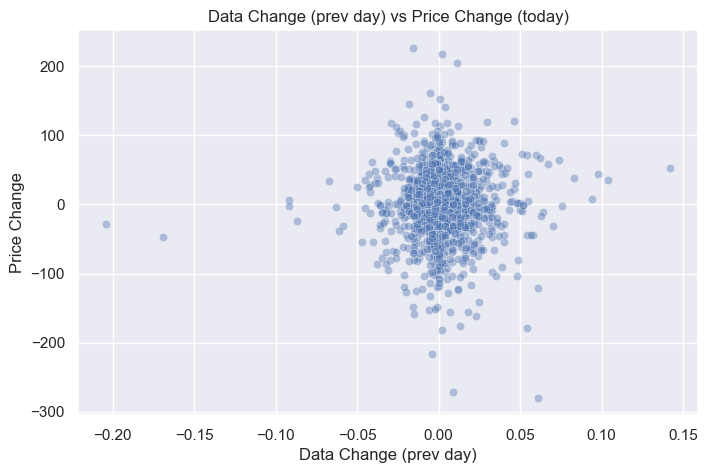

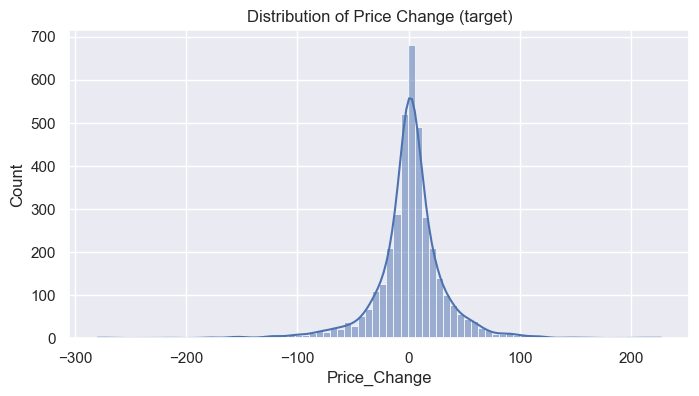

In [14]:
# Correlation and scatterplot
eda_df = df[['Date','Data_Change_PrevDay','Price_Change','Data_Pct_Change','Data_Rolling_STD']].copy()
print('Correlation matrix:')
print(eda_df[['Price_Change','Data_Change_PrevDay','Data_Pct_Change']].corr())

plt.figure(figsize=(8,5))
sns.scatterplot(x='Data_Change_PrevDay', y='Price_Change', data=eda_df, alpha=0.4)
plt.title('Data Change (prev day) vs Price Change (today)')
plt.xlabel('Data Change (prev day)')
plt.ylabel('Price Change')
plt.show()

# Distribution of target (price change)
plt.figure(figsize=(8,4))
sns.histplot(eda_df['Price_Change'], bins=80, kde=True)
plt.title('Distribution of Price Change (target)')
plt.show()

## 3 — Load generated diagnostics and metrics from `models/`
The training script produces many artifacts under `models/`. We load `metrics.json` and display diagnostic images produced by `src.train`.

Metrics (main model):
{
  "mse": 2371.7782196646126,
  "r2": -0.01637239893871456,
  "n_samples": 3797,
  "features": [
    "Data_Lag1",
    "Data_Change_PrevDay",
    "Data_Rolling_Mean"
  ],
  "target_transform": true
}


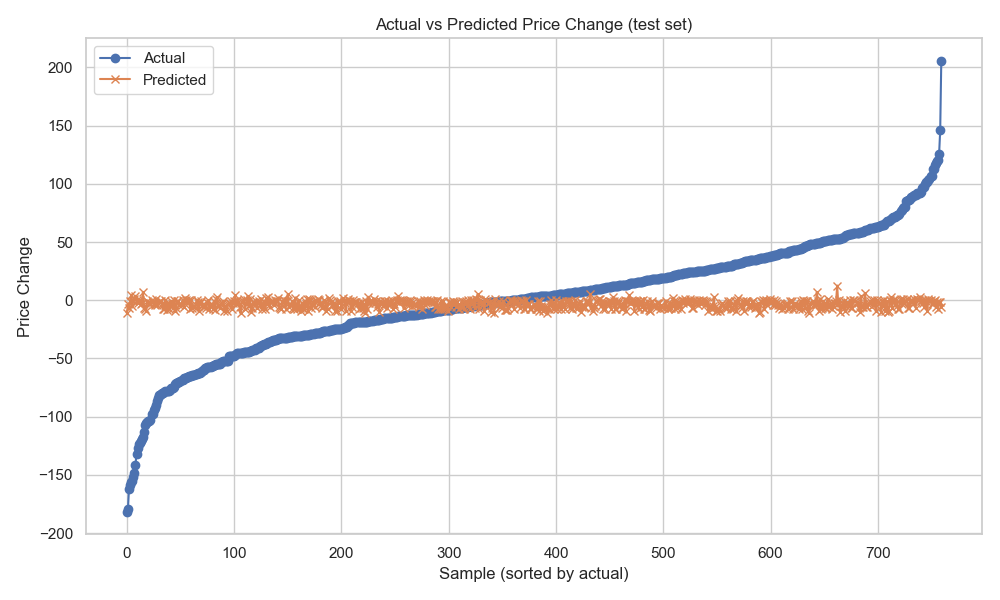

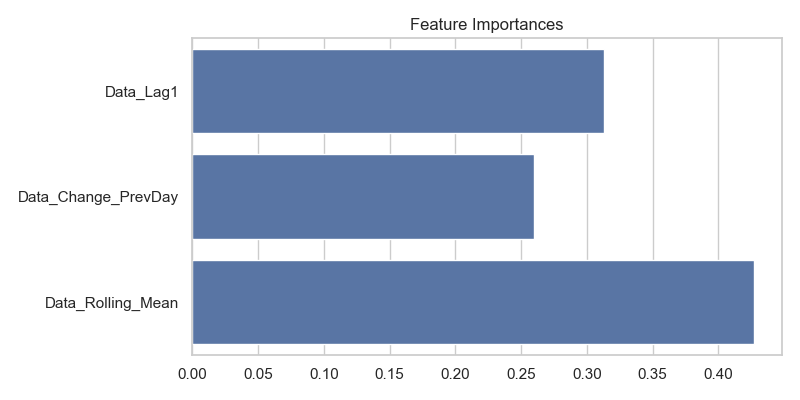

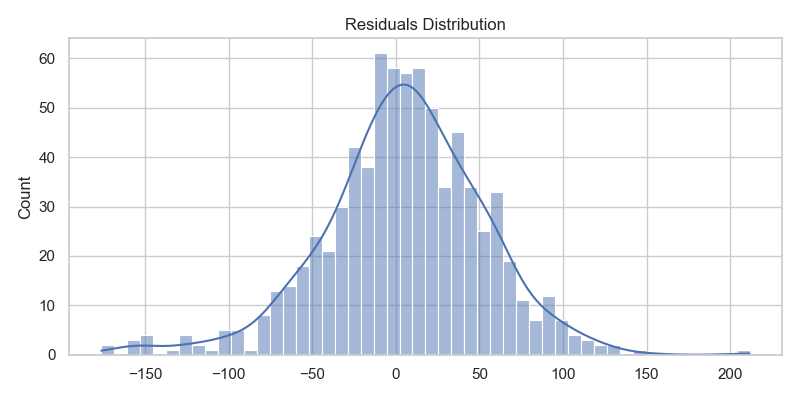

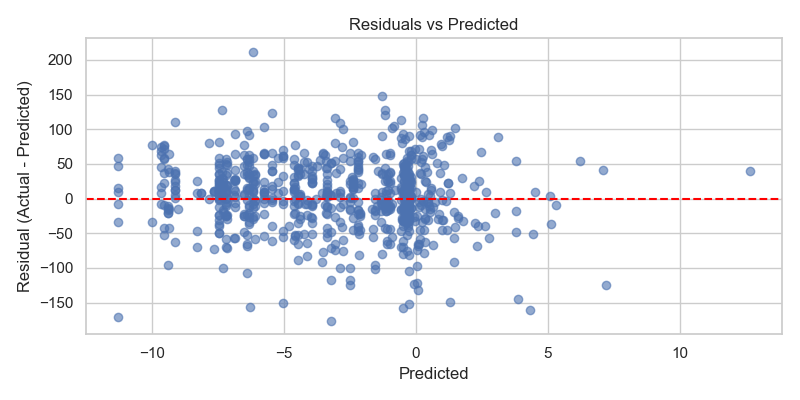

In [16]:
models_dir = os.path.join('..','models')
metrics_path = os.path.join(models_dir,'metrics.json')
if os.path.exists(metrics_path):
    with open(metrics_path,'r') as fh:
        metrics = json.load(fh)
    print('Metrics (main model):')
    print(json.dumps(metrics, indent=2))
else:
    print('metrics.json not found — run python -m src.train first')

# Display images if present
images = ['prediction_plot.png','feature_importance.png','residuals_hist.png','residuals_scatter.png']
for img in images:
    p = os.path.join(models_dir,img)
    if os.path.exists(p):
        display(Image(filename=p))
    else:
        print(img, 'not found')

# Extended metrics (if available)
metrics_ext_path = os.path.join(models_dir,'metrics_extended.json')
if os.path.exists(metrics_ext_path):
    with open(metrics_ext_path,'r') as fh:
        print('\nExtended metrics:')
        print(json.dumps(json.load(fh), indent=2))
    # show correlation heatmap and timeseries if present
    for ext_img in ['correlation_heatmap.png','timeseries_data_price.png','qqplot_residuals.png']:
        p = os.path.join(models_dir,ext_img)
        if os.path.exists(p):
            display(Image(filename=p))
        else:
            print(ext_img, 'not found')

## 4 — Inspect test predictions CSV and feature-target relationships
We saved `test_predictions.csv` and scatter plots per feature during training. Inspect a sample of the CSV to understand common errors and where residuals are large.

In [17]:
tp = os.path.join('..','models','test_predictions.csv')
if os.path.exists(tp):
    tdf = pd.read_csv(tp, index_col=0)
    display(tdf.head())
    print('Residuals summary:')
    display(tdf['residual'].describe())
else:
    print('test_predictions.csv not found — run python -m src.train')

,Data_Lag1,Data_Change_PrevDay,Data_Rolling_Mean,actual,predicted,residual
3042,-0.498,0.022,-0.5220,-29.75,-0.464169,-29.285831
3043,-0.499,-0.001,-0.5150,106.50,0.249399,106.250601
3044,-0.491,0.008,-0.5068,-18.00,2.987252,-20.987252
3045,-0.505,-0.014,-0.5026,-55.75,-0.909918,-54.840082
3046,-0.502,0.003,-0.4990,-29.50,1.021612,-30.521612


Residuals summary:


count    760.000000
mean       4.733157
std       48.502276
min     -176.276858
25%      -22.529607
50%        7.062263
75%       35.467353
max      211.672777
Name: residual, dtype: float64

## 5 — Recommendations & interpretation
- The scatter and correlation checks show whether `Data_Change_PrevDay` has a linear relationship with `Price_Change`. If correlation is weak, non-linear models or more features are required.
- Residuals plots and QQ-plot indicate heavy tails and heteroskedasticity. Consider target transforms (implemented in `src/train.py`) or robust models.
- Feature importance plots indicate which engineered features (lags, rolling std) contribute most to predictions — use these to guide further feature engineering.

### How previous-day change impacts price movement
- If the correlation is positive and statistically significant, an increase in `Data` previous-day change tends to increase `Price_Change` today. Use the scatter and regression coefficients (if applicable) to quantify this effect.
- If correlation is near zero, the `Data` signal alone is weak — combine multiple lags, rolling stats and volatility measures to improve predictive power.

## 6 — Next steps (automated experiments)
Run the following to retrain models or try variants:

```powershell
# retrain with current pipeline (produces artifacts in models/)
python -m src.train

# If you want to disable the signed-log target transform, edit src/train.py and set TARGET_TRANSFORM = False then re-run
```

You can also inspect `models/` images and CSVs to investigate model weaknesses and iterate.